# Model Fitness: Customer Interaction Analysis
One of the most common problems gyms and other services face is customer churn. How do we know if a customer is no longer with us? We can calculate churn based on people who get rid of their accounts or don't renew their contracts. However, sometimes it's not obvious that a client has left: they may walk out on tiptoes.

Churn indicators vary from field to field. If a user buys from an online store rarely but regularly, you can't say they're a runaway. But if for two weeks they haven't opened a channel that's updated daily, that's a reason to worry: your follower might have gotten bored and left you.

For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.

In order to fight churn, Model Fitness has digitized a number of its customer profiles. Our task is to analyze them and come up with a customer retention strategy. 

## Open the data file and read the general information

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mt
from functools import reduce
from plotly import graph_objects as go
import plotly.express as px
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline

In [2]:
gym_data=pd.read_csv('/datasets/gym_churn_us.csv')
gym_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym_data.columns=gym_data.columns.str.lower()
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

The data consists of 4000 rows and 14 columns. There are no missing values and dtypes are correct. We only made a change to the columns to be more consistent.

The dataset includes the following fields:                                                                                     
'Churn' — the fact of churn for the month in question                                                                        
Current dataset fields:                                                                                                         
User data for the preceding month                                                                                               
'gender'                                                                                                                       
'Near_Location' — whether the user lives or works in the neighborhood where the gym is located                                 
'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)                                                             
Promo_friends — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)                                                                                             
'Phone' — whether the user provided their phone number                                                                         
'Age'                                                                                                                           
'Lifetime' — the time (in months) since the customer first came to the gym                                                     
Data from the log of visits and purchases and data on current membership status                                                 
'Contract_period' — 1 month, 3 months, 6 months, or 1 year                                                                     
'Month_to_end_contract' — the months remaining until the contract expires                                                       
'Group_visits' — whether the user takes part in group sessions                                                                 
'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime                                 
'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month                             
'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.


## EDA

### Look at the dataset, does it contain any missing features? Study the mean values and standard deviation.

In [5]:
gym_data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [6]:
gym_data.duplicated().sum()

0

In [7]:
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


No missing values nor duplication found in the data. Looking at the descriptive statistics information, there's close to an equal number of men and women going to the gym with an average age of 29. Age ranges from 18 yrs old- 41yrs old. 84.5%  of Model Fitness customers live close to its location.                 

48.6% of users are an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers). 30.8% signed up through the " bring a friend" offer and 41.2% join in group sessions. The average contract is 4.6 months and the average term until the contract ends is 4.3 months.

### Look at the mean feature values in two groups: for those who left (churn) and for those who stayed.

In [8]:
# 0= stay, 1=leave
churn_groups= gym_data.groupby('churn').mean().T
churn_groups

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Looking at the table above, there isnt much of a difference between men and women who chose to stay or leave. We can tell that clients who lived closer to the gym were more likely to continue the contract. Users from partner companies, those who joined through the 'bring a friend' offer, and those who partake in group session are more likely to continue using the facility. The average contract for clients who stayed is about 5 months and for those who churned about a month. The average age of clients who stayed is 29 years old and those whose left average is 26. The average frequency of visits per week was lower for clients who left and 2x lower when looking at the visits per month compared to those who stayed.

### Plot bar histograms and feature distributions for those who left (churn) and those who stayed.

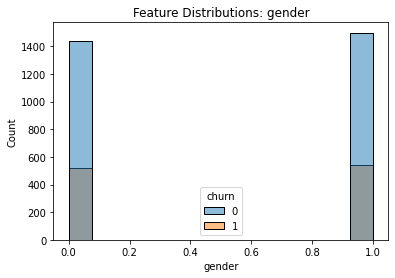

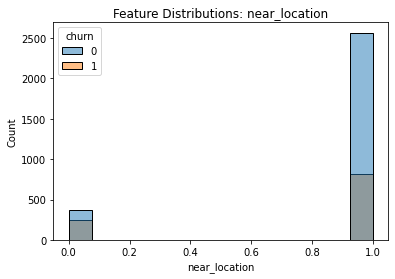

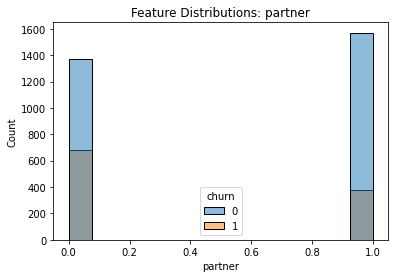

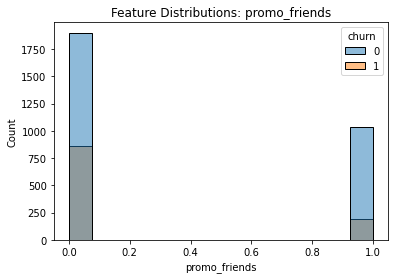

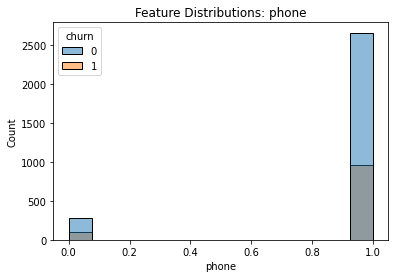

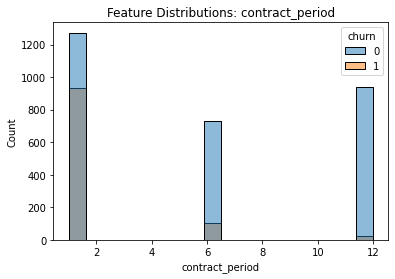

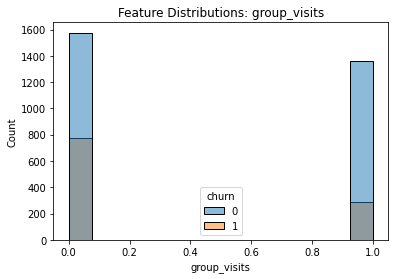

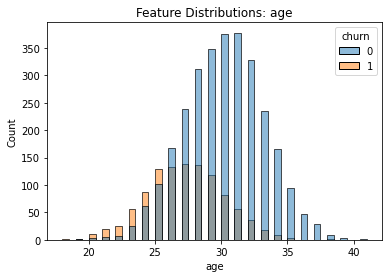

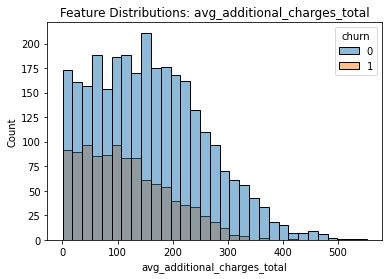

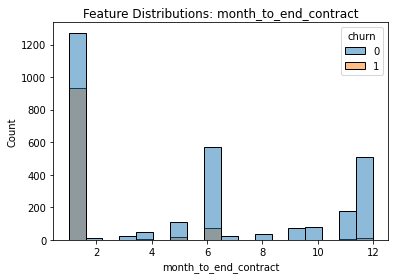

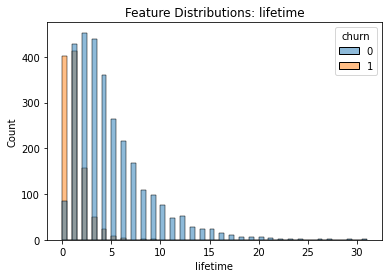

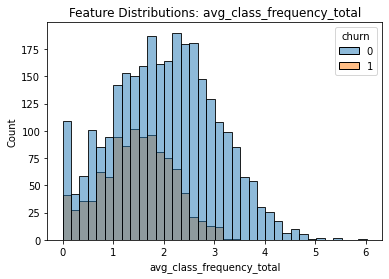

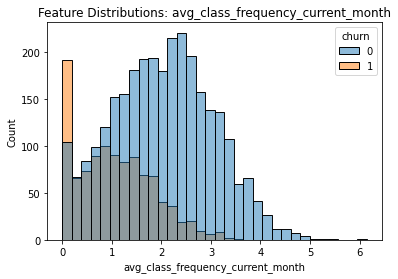

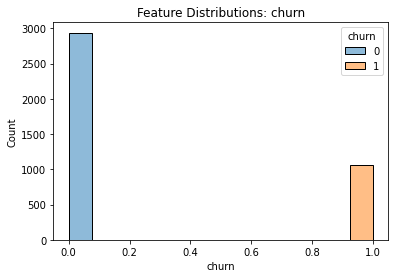

In [9]:
gym_columns= gym_data.columns
gym_columns

for features in gym_columns:
    sns.histplot(data=gym_data, x=features, hue='churn')
    plt.title('Feature Distributions: {}'.format(str(features)))
    plt.show();

For each distribution feature we can see the following:

Gender-> The rate of male/female who stayed or left looks to be equal or relatively close.

Near Location-> Clients who lived farther away were 5x more likely to leave compared to clients who lived near. This is to be expected as it is easier to be consistent if you dont have to travel far.

Partner-> Clients that are employees of a partner company are more likely to stay than those who have no affiliation to the gym.

Promo Friend -> Clients who joined throuhg the 'Bring a friend" offer less likely to leave than those who joined without the offer. Almost 2x more likely to stay.

Phone-> Majority of clients who sign up for the gym have provided their contact information.

Contract Period-> Majority of clients had a 1 month contract and more than half of those who did left. Clients with 6 month or yearly contract were less likely to leave.

Group Visits-> Of the clients who did not leave, a little more than half of them did not join any group sessions.

Age-> Clients between the ages of 20-25 were more likely to leave compared to older clients.

Additional Charges-> Clients who stayed spent a cosiderable amount of money on other services offered compated to those who left.

End of Contract-> Majority of clients who have a 1-2 month contract left. Longer contracts, 4+ months, had a smaller churning rate.

Lifetime-> As seen in other distribution charts, most users who have less than a 4 month contract have a higher propensity of leaving.

Visits per week-> Clients who visited the gym 1-2 times a week were more likely to leave than those who went more than twice in one week.


### Build a correlation matrix and display it.

In [10]:
corr_matrix= gym_data.corr()
corr_matrix

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


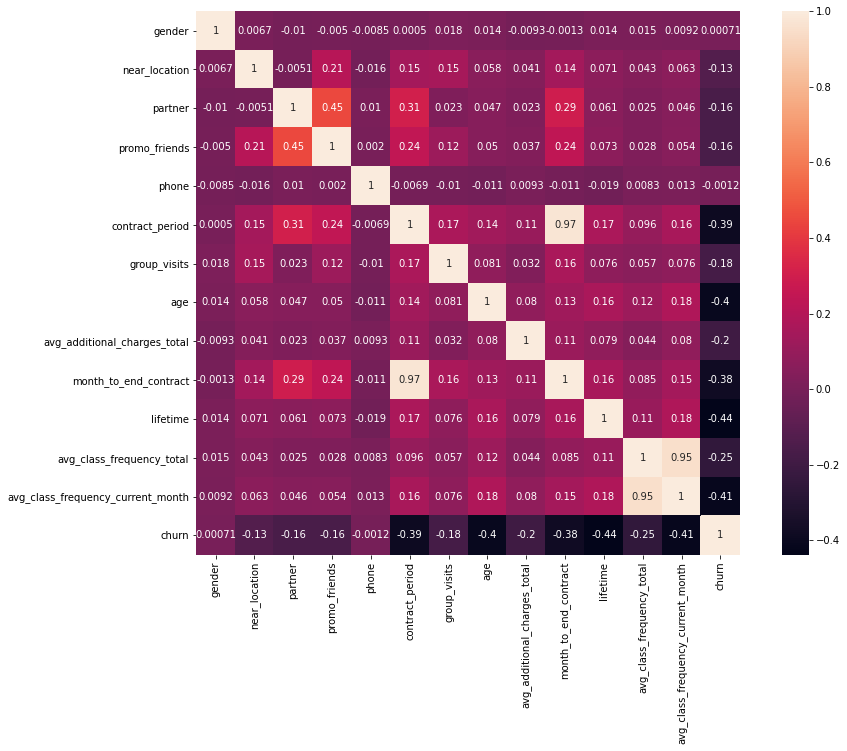

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, square=True)
plt.show()

The correlation matrix shows us that contract_period and month_to_end contract have a strong positive strong corr. The same applies to avg_visits_frequency(weekly) and avg_class_frequency_current_month. Feature with a negative correlation with churn are contract_period, age, month_to_end_contract, lifetime and avg_class_frequency_current_month.

## Build a model to predict user churn

### Divide the data into train and validation sets

In [12]:
# define the function that will output our metrics

def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [13]:
# divide the data into features (the X matrix) and a target variable (y)
X = gym_data.drop('churn', axis =1)
y = gym_data['churn']

# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardize the data using the StandardScaler method
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Train the model on the train set with two methods & Evaluate accuracy, precision, and recall 

In [14]:
# define the model's algorithm 
lr_model= LogisticRegression(random_state=0)
# train the model
lr_model.fit(X_train_st, y_train)
# use the trained model to make predictions
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# print all metrics
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')

Metrics for logistic regression:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [15]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# train the random forest model
rf_model.fit(X_train_st, y_train)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
# print all metrics
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Metrics for random forest:')

Metrics for random forest:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


We used two methods to train our models:                                                                                         
    -Logistic Regression & Random Forest                                                                                               
For both models the accuracy metric shows values above 90%; both coming out to 92%.
Precision tells us what share of predictions are in class 1 by looking at the share of correct answers only in the target class. For this particular method, logistic regression scored better, with an 85% compared to that of the random forest metric. The Recall method is used to minize risk and had a better score when using the logistic regression metric. When taking into account all 3 scores, logistic regression was the best metric used as it gave out better results.



## Create user clusters

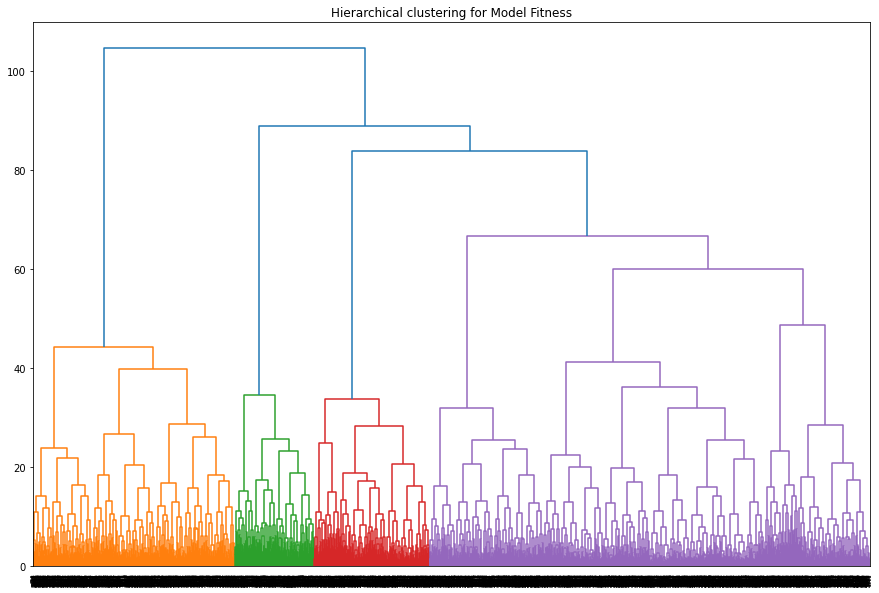

In [16]:
# standardization of data 
sc = StandardScaler()
x_sc = sc.fit_transform(X)

#Plot a dendogram
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for Model Fitness')
plt.show() 

In [17]:
# define the k_means model with 5 clusters
km = KMeans(n_clusters = 5)

# predict the clusters for observations 
labels = km.fit_predict(x_sc)

# store cluster labels into the field of our dataset
gym_data['cluster'] = labels

# get the statistics of the mean feature values per cluster
cluster_mean=gym_data.groupby(['cluster']).mean().reset_index()
cluster_mean

,cluster,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.497041,0.000000,0.461538,0.078895,1.000000,2.378698,0.218935,28.479290,135.631940,2.224852,2.812623,1.662253,1.480228,0.441815
1,1,0.500986,0.960552,0.783037,0.574951,1.000000,10.881657,0.540434,29.976331,160.780213,9.942801,4.712032,1.991934,1.984924,0.027613
2,2,0.555294,0.977647,0.355294,0.234118,0.998824,2.595294,0.475294,30.136471,162.726201,2.392941,5.016471,2.819152,2.817435,0.067059
3,3,0.488746,1.000000,0.350482,0.236334,1.000000,1.958199,0.339228,28.139068,130.415925,1.868167,2.347267,1.242795,1.004338,0.521704
4,4,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532


Cluster zero has the highest percentage of clients who came from partnerships and the bring a friend offer and 53% percent of their clients joined group sessions. Avg contract period was 10 months and most contract ended at 9.9 months.

Cluster one has 97% of its clients living/working nearby.

Cluster two- none of their clients lived/ worked nearby and almost half of them were employees of a partner company.

Cluster three- All of their clients lived/worked in the neighborhood but had the shortest contract period compared to all other clusters and had the highest churn rate.

Cluster four- None of their clients left their contact information.

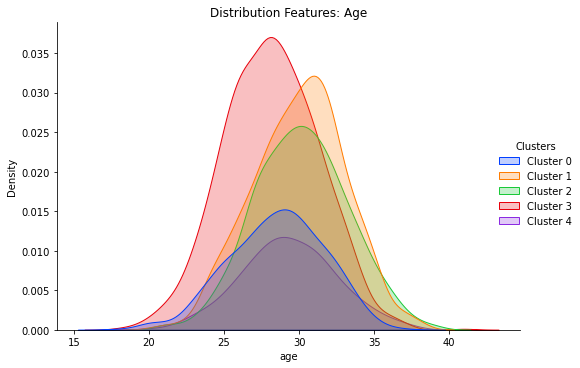

In [18]:
age_feature = sns.displot(data=gym_data, x='age', hue='cluster', kind='kde', fill=True, palette=sns.color_palette('bright')[:5],height=5, aspect=1.5)

new_title = 'Clusters'
age_feature._legend.set_title(new_title)


new_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4']
for t, l in zip(age_feature._legend.texts, new_labels):
    t.set_text(l)
plt.title('Distribution Features: Age');

There isn't a significant difference in age for the clusters. Avg age for all is within 28-30 yrs.

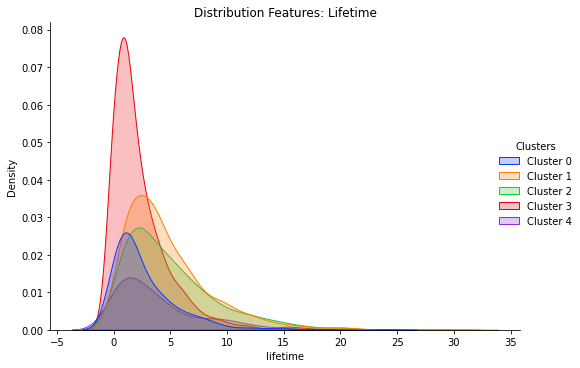

In [19]:
lifetime_feature = sns.displot(data=gym_data, x='lifetime', hue='cluster', kind='kde', fill=True, palette=sns.color_palette('bright')[:5],height=5, aspect=1.5)

new_title = 'Clusters'
lifetime_feature._legend.set_title(new_title)


new_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4']
for t, l in zip(lifetime_feature._legend.texts, new_labels):
    t.set_text(l)
plt.title('Distribution Features: Lifetime');

There is a vast difference in cluster three compared to the others. Majority of its clients had less than 3 months of lifetime.

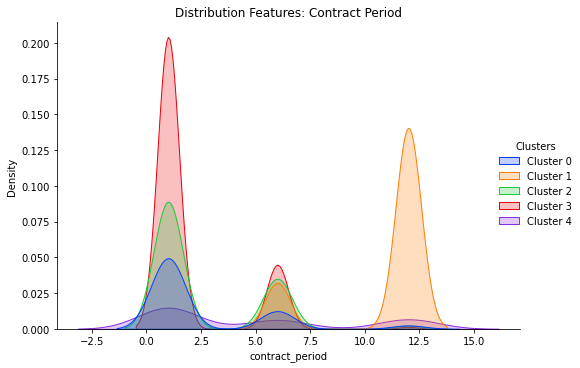

In [20]:
contract_period_feature = sns.displot(data=gym_data, x='contract_period', hue='cluster', kind='kde', fill=True, palette=sns.color_palette('bright')[:5],height=5, aspect=1.5)

new_title = 'Clusters'
contract_period_feature._legend.set_title(new_title)


new_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4']
for t, l in zip(contract_period_feature._legend.texts, new_labels):
    t.set_text(l)
plt.title('Distribution Features: Contract Period');

As stated previously, cluster 3 contract period is shorter than 3 months. Cluster 0 clients had contracts for longer periods, averaging at 12.5 months.

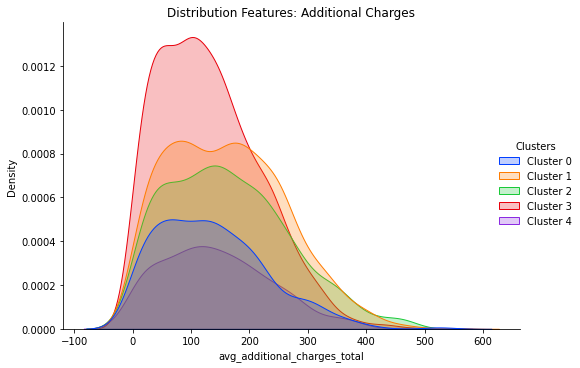

In [21]:
fee_feature = sns.displot(data=gym_data, x='avg_additional_charges_total', hue='cluster', kind='kde', fill=True, palette=sns.color_palette('bright')[:5],height=5, aspect=1.5)

new_title = 'Clusters'
fee_feature._legend.set_title(new_title)


new_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4']
for t, l in zip(fee_feature._legend.texts, new_labels):
    t.set_text(l)
plt.title('Distribution Features: Additional Charges');

As expected cluster 3 clients spent less money compared to other cluster as their clients had a higher rate of churning.

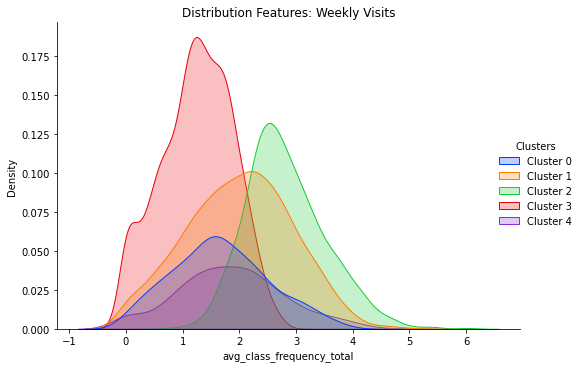

In [22]:
weekly_feature = sns.displot(data=gym_data, x='avg_class_frequency_total', hue='cluster', kind='kde', fill=True, palette=sns.color_palette('bright')[:5],height=5, aspect=1.5)

new_title = 'Clusters'
weekly_feature._legend.set_title(new_title)

new_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4']
for t, l in zip(weekly_feature._legend.texts, new_labels):
    t.set_text(l)
plt.title('Distribution Features: Weekly Visits');

This feels repetative buit again cluster 3 had less visits per week while cluster had a higher number of visits per week.

In [23]:
# Calculate Churn rate for the clusters

churn_rate= gym_data.groupby(['cluster'])['churn'].mean().reset_index()
churn_rate

,cluster,churn
0,0,0.441815
1,1,0.027613
2,2,0.067059
3,3,0.521704
4,4,0.267532


Most loyal clusters are 0 & 1. Cluster 2 & 3 are mostr likely to churn.

# Conclusions

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data. In order to fight churn, Model Fitness has digitized a number of its customer profiles. Your task is to analyze them and come up with a customer retention strategy. The data consists of 4000 rows and 14 columns. There are no missing values and dtypes are correct. We only made a change to the columns to be more consistent.

The dataset includes the following fields:
'Churn' — the fact of churn for the month in question
Current dataset fields:
User data for the preceding month
'gender'
'Near_Location' — whether the user lives or works in the neighborhood where the gym is located
'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
Promo_friends — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
'Phone' — whether the user provided their phone number
'Age'
'Lifetime' — the time (in months) since the customer first came to the gym
Data from the log of visits and purchases and data on current membership status
'Contract_period' — 1 month, 3 months, 6 months, or 1 year
'Month_to_end_contract' — the months remaining until the contract expires
'Group_visits' — whether the user takes part in group sessions
'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime
'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month
'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

When looking at the descriptive data we found that there's close to an equal number of men and women going to the gym with an average age of 29. Age ranges from 18 yrs old- 41yrs old. 84.5%  of Model Fitness customers live close to its location.                 
48.6% of users are an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers). 30.8% signed up through the " bring a friend" offer and 41.2% join in group sessions. The average contract is 4.6 months and the average term until the contract ends is 4.3 months.

We then looked at each features and compared the rates between those who churned and stayed and we found that there isnt much of a difference between men and women who chose to stay or leave. We can tell that clients who lived closer to the gym were more likely to continue the contract. Users from partner companies, those who joined through the 'bring a friend' offer, and those who partake in group session are more likely to continue using the facility. The average contract for clients who stayed is about 5 months and for those who churned about a month. The average age of clients who stayed is 29 years old and those whose left average is 26. The average frequency of visits per week was lower for clients who left and 2x lower when looking at the visits per month compared to those who stayed.

** Recommendations**

1. Advertise your group sessions-- Clients who join groups are less likely to churn. We can offer first time clients a free classes as an incentive. We can follow-up on our current members who have not joined and advertise via email or text. We can also create a system where members can accrue points based on how often they visit the gym and earn a class.

2. Utilize digital marketing strategies- Create a notification system for clients whose contracts are about to terminate and offer the oppurtunity to extend. We can use email or push notifications sendinf special discounts/classes that can only be used during their birthday months.

3. Use social media- By posting videos/stories, caption it may encourage clients to visit more frequently. This specifically will target the younger clients.

4. Get feedback- Do clients enjoy coming to your gym? Why or why not? Is our facility meeting their standards? Are we offering the right classes. This includes feedback about our staff and from our staff.